**Applied Machine Learning - Basic and Advanced**
**MNIST Project**
---
#University of Bologna - Italy

#Bioinformatics master degree

*Davide Abbondandolo*

---

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset. It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9. The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

## Modules import

In [ ]:
import numpy as np
import pandas as pd

from keras.datasets import mnist
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.svm import LinearSVC
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier



## Data import and analysis

In [ ]:
(train_images, train_label), (test_images, test_label) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
result = {}

First, we have to load the data, already split in train and test set.
We can now check how many samples we have.

In [ ]:
print('train_images: ' + str(train_images.shape))
print('train_label: ' + str(train_label.shape))
print('test_images:  '  + str(test_images.shape))
print('test_label:  '  + str(test_label.shape))

train_images: (60000, 28, 28)
train_label: (60000,)
test_images:  (10000, 28, 28)
test_label:  (10000,)


Each digit is represented by a 28x28 matrix, in which values inside each cell represent pixel intensity in greyscale. To transform this matrix into an actual image we can use the imshow() function. 

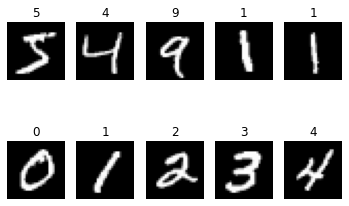

<Figure size 432x288 with 0 Axes>

In [ ]:
a=2
b=5
fig, axs = plt.subplots(a, b)
imgs=train_images[0:(a*b)]
fig = plt.figure()
i=0
j=0
for pic in range(len(imgs)):
    axs[i, j].imshow(train_images[pic], cmap='gray', vmin=0, vmax=255.)
    axs[i, j].set_title(train_label[pic])
    axs[i,j].axis('off')
    if i<a-1:
        i+=1
    else:
        i=0
        j+=1

We can also see the distribution of the different digits in the dataset

C:\Users\david\anaconda3\envs\AML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


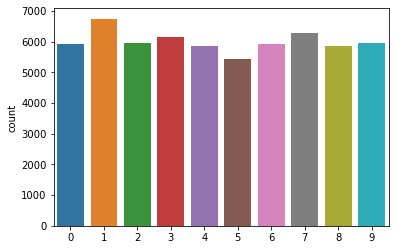

In [ ]:
count_plot = sns.countplot(train_label)

For some of our models, we need to reshape the input. Instead of having the feature in an NxN matrix, we will create a 1-D array of length N<sup>2</sup>, composed by the cell of the matrix. 


In [ ]:
train_images = train_images.flatten().reshape(60000,784)
test_images = test_images.flatten().reshape(10000,784)

## Decision Tree

### Basic Tree

The first model we are going to use is a decision tree. We are going to train the model on our train set and then evaluate its performance by predicting the label on the test set. The model result will be evaluated based on the [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. In a multiclass problem like MNIST, the score can be averaged in different ways. With average="micro" we calculate the score globally by counting the total true positives, false negatives and false positives.

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(train_images, train_label)
pred_label = tree_clf.predict(test_images)
score = f1_score(test_label, pred_label, average="micro")
print(score)

0.8755


This tree gives us an F1-score of 0,87. This results it's not bad, however since we did not give any parameters this tree is likely to be overfitted. By reading the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) we can learn that there is a parameter, max_depth which define the maximum depth of the tree. The standard value is None and if left unchanged, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. min_samples_split define the minimum number of samples required to split an internal node. Since it's standard value it's 2 this tree will divide node until they are composed only by single sample or until they are pure. This is a behaviour that will likely cause overfitting, so to avoid it we are going to try different values of max_depth and see which value will give us the best result.

### Grid search

To test the performance of our tree with different parameters we will use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV). This will enable us to train our model multiple times with different hyperparameter values and see which ones get the best score. The function will do a k-fold cross-validation (we will use the default value of 5) to choose the best.

In [ ]:
par_dict = {'max_depth': [10,20,30,40,50]}
grid_s = GridSearchCV(DecisionTreeClassifier(random_state=42), scoring="f1_micro",param_grid=par_dict, n_jobs=-1)
grid_s.fit(train_images, train_label)

Now we can check which model obtained the best results:


In [ ]:
grid_s.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

And, if we want, we can look at the score obtained for all the tested parameters:

In [ ]:
results = pd.DataFrame(grid_s.cv_results_)

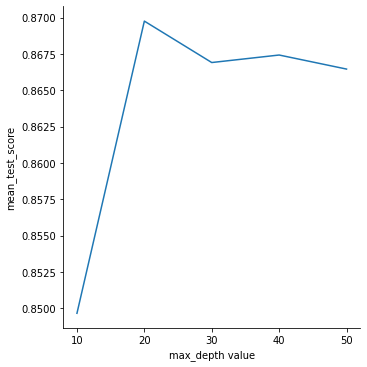

In [ ]:
cv_plot = sns.relplot(data=results, x=list(par_dict.values())[0], y="mean_test_score", kind="line")
cv_plot.set(xlabel='max_depth value')
cv_plot.ax.set_xticks(np.arange(10, 51,10))

From the GridSearch we can see that our model perform better with max_depth=20. Then the performance starts to decrease, probably due to overfitting. GridSearchCV has another useful parameter, refit (True by default), which allow us to predict directly from GridSearchCV using the model with the best parameters.

### Test set evaluation

In [ ]:
pred_label = grid_s.predict(test_images)
score=f1_score(test_label, pred_label, average="macro")
result["DT"]= score
print(score)

0.8802128807264291


The performance of our model is now slightly better with an F1-score of 0,88.
We can see which are the most common errors with a confusion matrix


<AxesSubplot:>

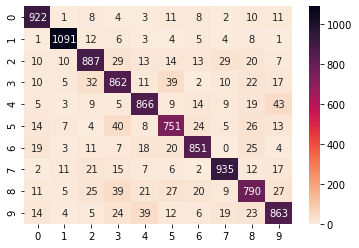

In [ ]:
cf_matrix = confusion_matrix(test_label, pred_label)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="rocket_r")

Most of the test set is well classified. The model tends to confuse and misclassify more those digits pair:
9-4
3-5
 
These digits are somehow similar, so the error can be explained. For other pairs of digits less similar, like 0-1 or 6-7, the error is almost zero. 

### Visualizing a decision Tree

We can visualize a tree in many ways. One of them is to use the built-in function of sklearn, tree.plot_tree(). Here we show our best tree with only the first 3 levels to make the image less messy. 

In [ ]:
best_tree = grid_s.best_estimator_
fig = plt.figure(figsize=(25,20), dpi=500)
feature_n= [str(i)+"_pix" for i in np.arange(1,28*28+1)]
name_c = [str(i) for i in np.arange(0,10)]
_ = tree.plot_tree(best_tree, feature_names=feature_n, class_names=name_c, max_depth=2)
fig.savefig("decistion_tree.png")

# SVM

Starting from the training set, an SVM algorithm maps training examples to points in space then try to find the hyperplane that maximises the width of the gap between the two categories. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall. In SVM we can define two types of margin:
- Hard: strictly impose the correct classification of all the sample
- Soft: find a balance between keeping the gap as large as possible and limiting the number of samples that are on the wrong side. 
 
To use SVM for multiple class classification problems we can implement a 1 vs 1 classifier for all possible pairs of classes or a 1 vs the others for each class. The first approach requires training way more classifiers and it's computationally expensive, so the second one is preferred. 


Many parameters can be adjusted in SVM. Some of the most interesting are:
- C: tells the SVM how much you want to avoid misclassifying each training example. Higher C tends to go toward a Hard margin, while with low C the classifier gets softer. 
- Kernel: mathematically is used to remap points into a higher dimensional space when they are not linearly separable in the current one. Is used to obtain a non-linear margin.
 
Since training SVM models with our dataset is quite slow, we will just try them using the 1 vs others approach with three different kernels: linear, polynomial and Radial basis function (RBF).


### Grid search

In [ ]:
kernel_CV = {'svc__kernel': ['rbf','linear','poly']}
                    
SVM_pipe = make_pipeline(StandardScaler(),
                   SVC())

In [ ]:
grid_SVM = GridSearchCV(SVM_pipe, scoring="f1_micro", param_grid=kernel_CV, n_jobs=-1)
grid_SVM.fit(train_images, train_label)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1, param_grid={'svc__kernel': ['rbf', 'linear', 'poly']},
             scoring='f1_micro')

In [ ]:
results = pd.DataFrame(grid_SVM.cv_results_)

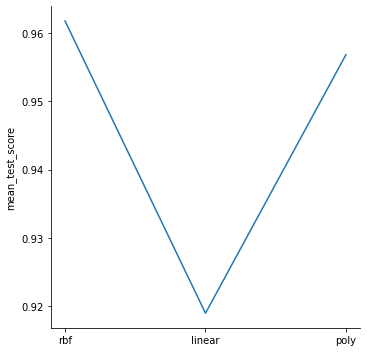

In [ ]:
cv_SVM_plot = sns.relplot(data=results, x=list(results["param_svc__kernel"]), y="mean_test_score", kind="line")

We can see that the polynomial (poly) and radial basis function (RBF) kernel outperform the linear one. This result was somehow expected since those two can create a non-linear margin. The best one, RBF, is used to evaluate our test set.

### Test set evaluation

In [ ]:
pred_label = grid_SVM.predict(test_images)
score=f1_score(test_label, pred_label, average="macro")
result["SVM"]= score
print(score)

0.9657584887464468


The performance of the model is quite good, with an F1-score of 0,96.

<AxesSubplot:>

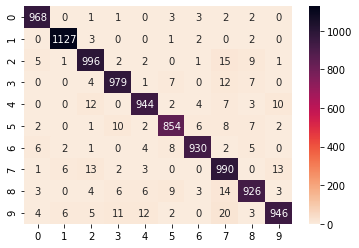

In [ ]:
cf_matrix = confusion_matrix(test_label, pred_label)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="rocket_r")

From the confusion matrix, we can see that errors are overall lower than before. It's worth mentioning that the most difficult pairs to evaluate are different from a DT, in which most of the errors were on the pair 9-4 and 3-5. Here we see 7-9 and 7-2 as the most troublesome. 

# Random forest

The general idea of ensemble methods is to train many different classifiers with decent accuracy. Then we can obtain a better classifier by aggregating the predictions from each classifier. To decide which class assign to a sample there are many ways:
- hard voting classifier: the class that gets the most votes gets assigned
- soft voting classifier: require classifiers that can estimate class probabilities. The class with the highest class probability averaged over all the individual classifiers is selected
- bagging: Instead of using different training algorithms to get different predictors in the ensemble, just use the same one for every predictor, but train them on different random subsets of the training set.
 
We will implement a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) which is an ensemble of DTs, generally trained via bagging. The Random Forest function adds an extra layer of randomness because when looking for the best feature to split it does not consider the whole set of features but a random subset of them. Like before, we will use a grid search to find the optimal number for some hyperparameters: the number of trees in the forest(n_estimators), the percentage of train set used to train each base estimator(max_samples), and the maximum depth of the tree(max_depth) 


### Grid search

In [ ]:
forest_par = {'n_estimators': [50,100], 'max_samples':[0.6,0.8], 'max_depth': [10,20,30]}

forest_clf = RandomForestClassifier(random_state=42)
forest_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=forest_par,scoring="f1_micro", n_jobs=-1)
forest_cv.fit(train_images, train_label)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'max_samples': [0.6, 0.8],
                         'n_estimators': [50, 100]},
             scoring='f1_micro')

Again we can look at the result of our cross-validation to establish the best parameters. 

In [ ]:
results = pd.DataFrame(forest_cv.cv_results_)

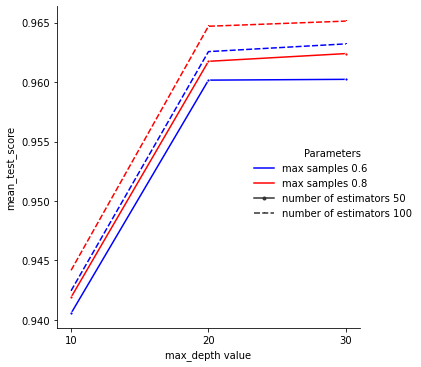

In [ ]:
cv_SVM_plot = sns.relplot(data=results, x=list(results["param_max_depth"]), y="mean_test_score", style=list(results["param_n_estimators"]), markers=["." , "," ], hue=list(results["param_max_samples"]), palette=["b", "r"], kind="line")
cv_SVM_plot.ax.set_xticks(np.arange(10, 31,10))
cv_SVM_plot.set(xlabel='max_depth value')
cv_SVM_plot._legend.set_title("Parameters")
new_labels = ["max samples " + str(i) for i in list(results["param_max_samples"].unique())] + ["number of estimators " + str(i) for i in list(results["param_n_estimators"].unique())] 
for t, l in zip(cv_SVM_plot._legend.texts, new_labels): t.set_text(l)


By plotting the results in a graph we can obtain a large amount of information. The best max depth value this time is 30. Instead for a single DT was 20. Moreover, we can observe that the model with 100 estimators is consistently better than the one with 50 (continuous vs dashed line) and that using 80% of the training sample give better results than 60% (red vs blue line). We could argue that using even more estimators can increase the performance even further, but for practical reasons we did not test it. Again, we can now use the best parameters combination to evaluate our final model. 

### Test set evaluation

In [ ]:
pred_label = forest_cv.predict(test_images)
score=f1_score(test_label, pred_label, average="macro")
result["RF"]= score
print(score)

0.9670961442286254


<AxesSubplot:>

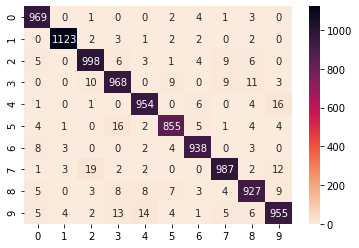

In [ ]:
cf_matrix = confusion_matrix(test_label, pred_label)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="rocket_r")

The ensemble of trees greatly decreases the error made by a single DT. However one of the most problematic pairs, 9-4, is still misclassified often. This happens less frequently in other models like SVM. 

To look further into this behaviour we can use a cool feature of Random Forest, which is the feature importance. In our example, we will see how much each pixel in the 28x28 pic is important for the model.

### Feature importance

In [ ]:
best_f = forest_cv.best_estimator_
importances = best_f.feature_importances_
importances = importances.reshape(28,28)

<AxesSubplot:>

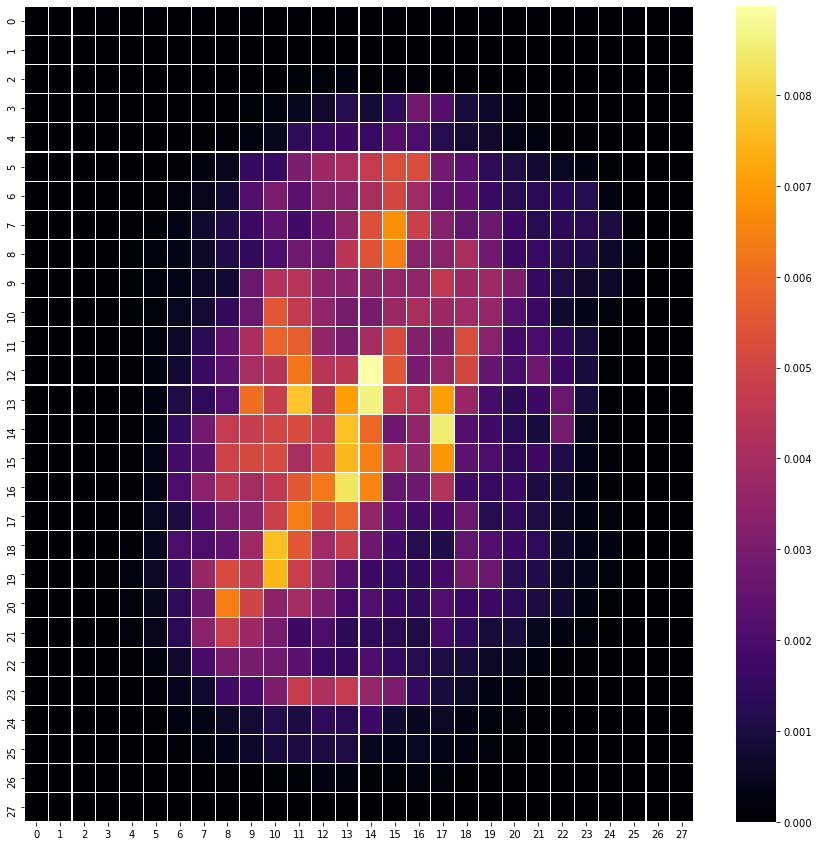

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(importances, linewidths=.1, cmap="inferno")

As expected, the most important pixels are in the middle. Maybe some of the pixels that would be able to correctly classify the problematic pairs are labelled as less important by the model and this would explain why we see a higher error rate for them. 


# Neural Network

In neural networks, many parameters define the network’s architecture and influence its performance:
- Number of layers
- Number of nodes in each of those layers
- Transfer/activation function used at each of those layers
- Loss function used
- Optimization algorithm used
- Number of training epochs
 
To simplify a bit this work some of them are going to be fixed, so it will be easier to compare the influence of the one we are going to change. All of the network architectures will use the rectified linear unit (ReLu) for all of the hidden layers, the loss function will be categorical cross-entropy and the optimization algorithms will be adam.
We will use the [NN implementation](https://keras.io/api/) of the package Keras. 


### Data preparation

Before starting to use NN we need to take care of few things. The labels for this dataset are numerical values from 0 to 9 — but our algorithm must treat these as items in a set, rather than ordinal values. In our dataset the value 0 isn’t smaller than the value 9, they are just two different values from our set of possible classifications. To address this issue the best practice is to use a “one-hot encoded” vector. This means that we create a vector as long as the number of categories we have, and force the model to set exactly one of the positions in the vector to 1 and the rest to 0 (the single 1 is the “hot” value within the vector). Moreover, we normalize our data. 

In [ ]:
image_size = 784 # 28*28
num_classes = 10 # ten unique digits
train_label2 = to_categorical(train_label, num_classes)
test_label2 = to_categorical(test_label, num_classes)

In [ ]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

### Basic NN

Now we can create our first NN. We define the input layer as a vector with 784 entries since earlier we rearrange our data like this. The output layer is instead defined by the one-hot encoded vector that we just create. 
Our output layer will also use a special activation function called softmax. This normalizes the values from the ten output nodes so all the values will be between 0 and 1, and their sum is 1.
This allows us to treat those ten output values as probabilities, and the largest one is selected as the prediction for the one-hot vector.

In [ ]:
model = Sequential()
model.add(Dense(units=32, activation='relu', input_shape=(image_size,)))
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


This model has a single hidden layer with 32 nodes and uses the sigmoid activation function. We can look at the number of tunable parameters with model.summary(). 

Before learning we use compile() to specify an optimizer, the loss function to use and the metrics that you want to log during training.

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Then we can fit our model with fit(), similar to sklearn fit method. However, here we need to specify also batch_size that defines the number of samples that will be propagated through the network at each iteration, for how many epochs we train and the amount of data to use for validation (in our case 0.1= 10% of 60000 = 6000). We can follow the evolution of the model during the epoch by looking at the fit callback, that we assing to the variable history. 
For this first model, we train for 10 epochs.

In [ ]:
history = model.fit(train_images, train_label2, batch_size=128, epochs=10,  validation_split=.1)

Epoch 1/10
422/422 [==============================] - 0s 858us/step - loss: 0.5218 - accuracy: 0.8590 - val_loss: 0.2400 - val_accuracy: 0.9338
Epoch 2/10
422/422 [==============================] - 0s 591us/step - loss: 0.2674 - accuracy: 0.9246 - val_loss: 0.1970 - val_accuracy: 0.9460
Epoch 3/10
422/422 [==============================] - 0s 581us/step - loss: 0.2235 - accuracy: 0.9374 - val_loss: 0.1703 - val_accuracy: 0.9527
Epoch 4/10
422/422 [==============================] - 0s 579us/step - loss: 0.1917 - accuracy: 0.9456 - val_loss: 0.1497 - val_accuracy: 0.9593
Epoch 5/10
422/422 [==============================] - 0s 584us/step - loss: 0.1693 - accuracy: 0.9524 - val_loss: 0.1402 - val_accuracy: 0.9617
Epoch 6/10
422/422 [==============================] - 0s 584us/step - loss: 0.1519 - accuracy: 0.9572 - val_loss: 0.1316 - val_accuracy: 0.9642
Epoch 7/10
422/422 [==============================] - 0s 577us/step - loss: 0.1385 - accuracy: 0.9608 - val_loss: 0.1240 - val_accuracy:

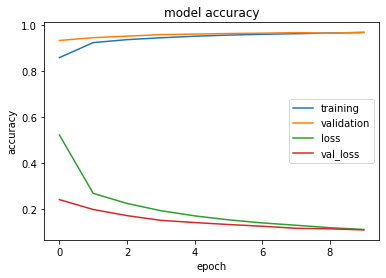

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss','val_loss'])
plt.show()

We can use the history variable to plot the evolution of the training during the epochs. We can see that the accuracy score is still increasing for training and validation set as the epoch increase, this could mean that training for more epochs could lead to even better results. We are happy with our training, we can use evaluate() to check the performance on our test set. This function returns the loss value and the accuracy.

In [ ]:
loss, accuracy  = model.evaluate(test_images, test_label2)

313/313 [==============================] - 0s 344us/step - loss: 0.1313 - accuracy: 0.9617


The result is not bad, but we can do better!

### Grid search

Now let's try to optimize our NN. We create the function create_model(), and we feed it the number of neurons in the first and second hidden layer as hyperparameters. Moreover, we train the model for different epochs, to monitor the impact of the training length on the results.

In [ ]:
def create_model(optimizer='adam', hidden_size=32, hidden_size2=False):
    model = Sequential()
    
    model.add(Dense(hidden_size, activation='relu', input_shape=(784,)))

    if hidden_size2:
        model.add(Dense(hidden_size2, activation = 'relu'))
    
    model.add(Dense(units=10, activation='softmax'))

    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])    
    return model    


model = KerasClassifier(create_model)
NN_param={'epochs':[1,5,10,20],'hidden_size': [32,64,256], 'hidden_size2':[False,32]}

grid_NN = GridSearchCV(model, param_grid=NN_param, return_train_score=True)

grid_NN.fit(train_images, train_label2)

375/375 [==============================] - 0s 414us/step - loss: 0.1526 - accuracy: 0.9555


1500/1500 [==============================] - 1s 402us/step - loss: 0.1152 - accuracy: 0.9673
Epoch 1/5
1500/1500 [==============================] - 1s 436us/step - loss: 0.3931 - accuracy: 0.8913
Epoch 2/5
1500/1500 [==============================] - 1s 433us/step - loss: 0.2090 - accuracy: 0.9392
Epoch 3/5
1500/1500 [==============================] - 1s 434us/step - loss: 0.1700 - accuracy: 0.9498
Epoch 4/5
1500/1500 [==============================] - 1s 437us/step - loss: 0.1460 - accuracy: 0.9570
Epoch 5/5
1500/1500 [==============================] - 0s 332us/step - loss: 0.1081 - accuracy: 0.9682
Epoch 1/5
1500/1500 [==============================] - 1s 445us/step - loss: 0.3842 - accuracy: 0.8927
Epoch 2/5
1500/1500 [==============================] - 1s 443us/step - loss: 0.2018 - accuracy: 0.9430
Epoch 3/5
1500/1500 [==============================] - 1s 441us/step - loss: 0.1583 - accuracy: 0.9550
Epoch 4/5
1500/1500 [==============================] - 1s 457us/step - loss: 0.1325

1500/1500 [==============================] - 1s 354us/step - loss: 0.0921 - accuracy: 0.9715
Epoch 1/5
1500/1500 [==============================] - 1s 462us/step - loss: 0.3711 - accuracy: 0.8915
Epoch 2/5
1500/1500 [==============================] - 1s 461us/step - loss: 0.1701 - accuracy: 0.9495
Epoch 3/5
1500/1500 [==============================] - 1s 467us/step - loss: 0.1330 - accuracy: 0.9602
Epoch 4/5
1500/1500 [==============================] - 1s 473us/step - loss: 0.1104 - accuracy: 0.9673
Epoch 5/5
1500/1500 [==============================] - 1s 351us/step - loss: 0.0745 - accuracy: 0.9775
Epoch 1/5
1500/1500 [==============================] - 1s 454us/step - loss: 0.3732 - accuracy: 0.8901
Epoch 2/5
1500/1500 [==============================] - 1s 467us/step - loss: 0.1751 - accuracy: 0.9490
Epoch 3/5
1500/1500 [==============================] - 1s 467us/step - loss: 0.1384 - accuracy: 0.9591
Epoch 4/5
1500/1500 [==============================] - 1s 468us/step - loss: 0.1161

1500/1500 [==============================] - 1s 481us/step - loss: 0.1062 - accuracy: 0.9682
Epoch 4/5
1500/1500 [==============================] - 1s 477us/step - loss: 0.0829 - accuracy: 0.9746
Epoch 5/5
1500/1500 [==============================] - 1s 352us/step - loss: 0.0456 - accuracy: 0.9865
Epoch 1/5
1500/1500 [==============================] - 1s 481us/step - loss: 0.3228 - accuracy: 0.9057
Epoch 2/5
1500/1500 [==============================] - 1s 503us/step - loss: 0.1520 - accuracy: 0.9553
Epoch 3/5
1500/1500 [==============================] - 1s 495us/step - loss: 0.1132 - accuracy: 0.9654
Epoch 4/5
1500/1500 [==============================] - 1s 492us/step - loss: 0.0896 - accuracy: 0.9727
Epoch 5/5
1500/1500 [==============================] - 1s 359us/step - loss: 0.0633 - accuracy: 0.9801
Epoch 1/5
1500/1500 [==============================] - 1s 588us/step - loss: 0.2487 - accuracy: 0.9289
Epoch 2/5
1500/1500 [==============================] - 1s 583us/step - loss: 0.1054

1500/1500 [==============================] - 1s 638us/step - loss: 0.1034 - accuracy: 0.9687
Epoch 3/5
1500/1500 [==============================] - 1s 647us/step - loss: 0.0697 - accuracy: 0.9791
Epoch 4/5
1500/1500 [==============================] - 1s 651us/step - loss: 0.0490 - accuracy: 0.9849
Epoch 5/5
1500/1500 [==============================] - 1s 426us/step - loss: 0.0330 - accuracy: 0.9901
Epoch 1/10
1500/1500 [==============================] - 1s 444us/step - loss: 0.3821 - accuracy: 0.8917
Epoch 2/10
1500/1500 [==============================] - 1s 434us/step - loss: 0.2035 - accuracy: 0.9416
Epoch 3/10
1500/1500 [==============================] - 1s 433us/step - loss: 0.1582 - accuracy: 0.9553
Epoch 4/10
1500/1500 [==============================] - 1s 436us/step - loss: 0.1314 - accuracy: 0.9622
Epoch 5/10
1500/1500 [==============================] - 1s 435us/step - loss: 0.1156 - accuracy: 0.9661
Epoch 6/10
1500/1500 [==============================] - 1s 435us/step - loss: 

1500/1500 [==============================] - 1s 455us/step - loss: 0.1476 - accuracy: 0.9564
Epoch 4/10
1500/1500 [==============================] - 1s 455us/step - loss: 0.1235 - accuracy: 0.9638
Epoch 5/10
1500/1500 [==============================] - 1s 455us/step - loss: 0.1067 - accuracy: 0.9686
Epoch 6/10
1500/1500 [==============================] - 1s 458us/step - loss: 0.0936 - accuracy: 0.9720
Epoch 7/10
1500/1500 [==============================] - 1s 459us/step - loss: 0.0834 - accuracy: 0.9736
Epoch 8/10
1500/1500 [==============================] - 1s 476us/step - loss: 0.0739 - accuracy: 0.9782
Epoch 9/10
1500/1500 [==============================] - 1s 462us/step - loss: 0.0676 - accuracy: 0.9789
Epoch 10/10
1500/1500 [==============================] - 1s 341us/step - loss: 0.0470 - accuracy: 0.9859
Epoch 1/10
1500/1500 [==============================] - 1s 459us/step - loss: 0.3853 - accuracy: 0.8876
Epoch 2/10
1500/1500 [==============================] - 1s 456us/step - lo

1500/1500 [==============================] - 1s 460us/step - loss: 0.0580 - accuracy: 0.9827
Epoch 7/10
1500/1500 [==============================] - 1s 461us/step - loss: 0.0504 - accuracy: 0.9849
Epoch 8/10
1500/1500 [==============================] - 1s 462us/step - loss: 0.0424 - accuracy: 0.9870
Epoch 9/10
1500/1500 [==============================] - 1s 461us/step - loss: 0.0369 - accuracy: 0.9889
Epoch 10/10
1500/1500 [==============================] - 1s 353us/step - loss: 0.0222 - accuracy: 0.9939
Epoch 1/10
1500/1500 [==============================] - 1s 460us/step - loss: 0.3301 - accuracy: 0.9077
Epoch 2/10
1500/1500 [==============================] - 1s 477us/step - loss: 0.1578 - accuracy: 0.9547
Epoch 3/10
1500/1500 [==============================] - 1s 456us/step - loss: 0.1143 - accuracy: 0.9658
Epoch 4/10
1500/1500 [==============================] - 1s 458us/step - loss: 0.0892 - accuracy: 0.9737
Epoch 5/10
1500/1500 [==============================] - 1s 460us/step - lo

1500/1500 [==============================] - 1s 360us/step - loss: 0.0210 - accuracy: 0.9934
Epoch 1/10
1500/1500 [==============================] - 1s 477us/step - loss: 0.3273 - accuracy: 0.9053
Epoch 2/10
1500/1500 [==============================] - 1s 476us/step - loss: 0.1482 - accuracy: 0.9564
Epoch 3/10
1500/1500 [==============================] - 1s 474us/step - loss: 0.1086 - accuracy: 0.9671
Epoch 4/10
1500/1500 [==============================] - 1s 501us/step - loss: 0.0879 - accuracy: 0.9731
Epoch 5/10
1500/1500 [==============================] - 1s 485us/step - loss: 0.0712 - accuracy: 0.9776
Epoch 6/10
1500/1500 [==============================] - 1s 475us/step - loss: 0.0599 - accuracy: 0.9813
Epoch 7/10
1500/1500 [==============================] - 1s 479us/step - loss: 0.0508 - accuracy: 0.9842
Epoch 8/10
1500/1500 [==============================] - 1s 497us/step - loss: 0.0427 - accuracy: 0.9864
Epoch 9/10
1500/1500 [==============================] - 1s 475us/step - los

1500/1500 [==============================] - 1s 618us/step - loss: 0.0132 - accuracy: 0.9961
Epoch 10/10
1500/1500 [==============================] - 1s 399us/step - loss: 0.0131 - accuracy: 0.9957
Epoch 1/10
1500/1500 [==============================] - 1s 630us/step - loss: 0.2586 - accuracy: 0.9246
Epoch 2/10
1500/1500 [==============================] - 1s 638us/step - loss: 0.1051 - accuracy: 0.9680
Epoch 3/10
1500/1500 [==============================] - 1s 656us/step - loss: 0.0689 - accuracy: 0.9789
Epoch 4/10
1500/1500 [==============================] - 1s 676us/step - loss: 0.0497 - accuracy: 0.9839
Epoch 5/10
1500/1500 [==============================] - 1s 686us/step - loss: 0.0386 - accuracy: 0.9883
Epoch 6/10
1500/1500 [==============================] - 1s 658us/step - loss: 0.0315 - accuracy: 0.9898
Epoch 7/10
1500/1500 [==============================] - 1s 654us/step - loss: 0.0250 - accuracy: 0.9914
Epoch 8/10
1500/1500 [==============================] - 1s 707us/step - lo

1500/1500 [==============================] - 1s 433us/step - loss: 0.0772 - accuracy: 0.9759
Epoch 10/20
1500/1500 [==============================] - 1s 434us/step - loss: 0.0706 - accuracy: 0.9781
Epoch 11/20
1500/1500 [==============================] - 1s 434us/step - loss: 0.0648 - accuracy: 0.9798
Epoch 12/20
1500/1500 [==============================] - 1s 433us/step - loss: 0.0592 - accuracy: 0.9814
Epoch 13/20
1500/1500 [==============================] - 1s 434us/step - loss: 0.0560 - accuracy: 0.9825
Epoch 14/20
1500/1500 [==============================] - 1s 434us/step - loss: 0.0517 - accuracy: 0.9837
Epoch 15/20
1500/1500 [==============================] - 1s 434us/step - loss: 0.0486 - accuracy: 0.9851
Epoch 16/20
1500/1500 [==============================] - 1s 444us/step - loss: 0.0452 - accuracy: 0.9859
Epoch 17/20
1500/1500 [==============================] - 1s 438us/step - loss: 0.0424 - accuracy: 0.9871
Epoch 18/20
1500/1500 [==============================] - 1s 434us/s

1500/1500 [==============================] - 1s 339us/step - loss: 0.0292 - accuracy: 0.9915
Epoch 1/20
1500/1500 [==============================] - 1s 441us/step - loss: 0.3915 - accuracy: 0.8916
Epoch 2/20
1500/1500 [==============================] - 1s 439us/step - loss: 0.2065 - accuracy: 0.9410
Epoch 3/20
1500/1500 [==============================] - 1s 440us/step - loss: 0.1626 - accuracy: 0.9526
Epoch 4/20
1500/1500 [==============================] - 1s 441us/step - loss: 0.1369 - accuracy: 0.9597
Epoch 5/20
1500/1500 [==============================] - 1s 442us/step - loss: 0.1195 - accuracy: 0.9654
Epoch 6/20
1500/1500 [==============================] - 1s 442us/step - loss: 0.1049 - accuracy: 0.9691
Epoch 7/20
1500/1500 [==============================] - 1s 443us/step - loss: 0.0950 - accuracy: 0.9718
Epoch 8/20
1500/1500 [==============================] - 1s 467us/step - loss: 0.0855 - accuracy: 0.9744
Epoch 9/20
1500/1500 [==============================] - 1s 448us/step - los

1500/1500 [==============================] - 1s 462us/step - loss: 0.0569 - accuracy: 0.9824
Epoch 11/20
1500/1500 [==============================] - 1s 461us/step - loss: 0.0513 - accuracy: 0.9834
Epoch 12/20
1500/1500 [==============================] - 1s 463us/step - loss: 0.0478 - accuracy: 0.9839
Epoch 13/20
1500/1500 [==============================] - 1s 480us/step - loss: 0.0419 - accuracy: 0.9872
Epoch 14/20
1500/1500 [==============================] - 1s 462us/step - loss: 0.0409 - accuracy: 0.9862
Epoch 15/20
1500/1500 [==============================] - 1s 463us/step - loss: 0.0371 - accuracy: 0.9882
Epoch 16/20
1500/1500 [==============================] - 1s 465us/step - loss: 0.0342 - accuracy: 0.9889
Epoch 17/20
1500/1500 [==============================] - 1s 463us/step - loss: 0.0314 - accuracy: 0.9897
Epoch 18/20
1500/1500 [==============================] - 1s 477us/step - loss: 0.0294 - accuracy: 0.9901
Epoch 19/20
1500/1500 [==============================] - 1s 469us/s

1500/1500 [==============================] - 1s 350us/step - loss: 0.0071 - accuracy: 0.9982
Epoch 1/20
1500/1500 [==============================] - 1s 457us/step - loss: 0.3267 - accuracy: 0.9088
Epoch 2/20
1500/1500 [==============================] - 1s 455us/step - loss: 0.1628 - accuracy: 0.9529
Epoch 3/20
1500/1500 [==============================] - 1s 455us/step - loss: 0.1199 - accuracy: 0.9651
Epoch 4/20
1500/1500 [==============================] - 1s 455us/step - loss: 0.0962 - accuracy: 0.9721
Epoch 5/20
1500/1500 [==============================] - 1s 457us/step - loss: 0.0782 - accuracy: 0.9761
Epoch 6/20
1500/1500 [==============================] - 1s 457us/step - loss: 0.0652 - accuracy: 0.9804
Epoch 7/20
1500/1500 [==============================] - 1s 476us/step - loss: 0.0558 - accuracy: 0.9830
Epoch 8/20
1500/1500 [==============================] - 1s 491us/step - loss: 0.0482 - accuracy: 0.9850
Epoch 9/20
1500/1500 [==============================] - 1s 455us/step - los

1500/1500 [==============================] - 1s 455us/step - loss: 0.0390 - accuracy: 0.9887
Epoch 10/20
1500/1500 [==============================] - 1s 451us/step - loss: 0.0331 - accuracy: 0.9901
Epoch 11/20
1500/1500 [==============================] - 1s 453us/step - loss: 0.0308 - accuracy: 0.9904
Epoch 12/20
1500/1500 [==============================] - 1s 453us/step - loss: 0.0246 - accuracy: 0.9924
Epoch 13/20
1500/1500 [==============================] - 1s 453us/step - loss: 0.0215 - accuracy: 0.9937
Epoch 14/20
1500/1500 [==============================] - 1s 454us/step - loss: 0.0207 - accuracy: 0.9935
Epoch 15/20
1500/1500 [==============================] - 1s 455us/step - loss: 0.0164 - accuracy: 0.9952
Epoch 16/20
1500/1500 [==============================] - 1s 453us/step - loss: 0.0156 - accuracy: 0.9952
Epoch 17/20
1500/1500 [==============================] - 1s 453us/step - loss: 0.0125 - accuracy: 0.9967
Epoch 18/20
1500/1500 [==============================] - 1s 473us/s

1500/1500 [==============================] - 1s 476us/step - loss: 0.0132 - accuracy: 0.9954
Epoch 20/20
1500/1500 [==============================] - 1s 359us/step - loss: 0.0171 - accuracy: 0.9941
Epoch 1/20
1500/1500 [==============================] - 1s 474us/step - loss: 0.3238 - accuracy: 0.9085
Epoch 2/20
1500/1500 [==============================] - 1s 473us/step - loss: 0.1541 - accuracy: 0.9543
Epoch 3/20
1500/1500 [==============================] - 1s 473us/step - loss: 0.1113 - accuracy: 0.9661
Epoch 4/20
1500/1500 [==============================] - 1s 504us/step - loss: 0.0860 - accuracy: 0.9730
Epoch 5/20
1500/1500 [==============================] - 1s 493us/step - loss: 0.0723 - accuracy: 0.9775
Epoch 6/20
1500/1500 [==============================] - 1s 475us/step - loss: 0.0585 - accuracy: 0.9816
Epoch 7/20
1500/1500 [==============================] - 1s 473us/step - loss: 0.0490 - accuracy: 0.9843
Epoch 8/20
1500/1500 [==============================] - 1s 477us/step - lo

Epoch 8/20
1500/1500 [==============================] - 1s 630us/step - loss: 0.0179 - accuracy: 0.9941
Epoch 9/20
1500/1500 [==============================] - 1s 624us/step - loss: 0.0132 - accuracy: 0.9958
Epoch 10/20
1500/1500 [==============================] - 1s 625us/step - loss: 0.0111 - accuracy: 0.9967
Epoch 11/20
1500/1500 [==============================] - 1s 621us/step - loss: 0.0100 - accuracy: 0.9970
Epoch 12/20
1500/1500 [==============================] - 1s 622us/step - loss: 0.0085 - accuracy: 0.9972
Epoch 13/20
1500/1500 [==============================] - 1s 618us/step - loss: 0.0082 - accuracy: 0.9974
Epoch 14/20
1500/1500 [==============================] - 1s 626us/step - loss: 0.0061 - accuracy: 0.9983
Epoch 15/20
1500/1500 [==============================] - 1s 622us/step - loss: 0.0066 - accuracy: 0.9979
Epoch 16/20
1500/1500 [==============================] - 1s 666us/step - loss: 0.0082 - accuracy: 0.9972
Epoch 17/20
1500/1500 [==============================] - 

1500/1500 [==============================] - 1s 618us/step - loss: 0.0044 - accuracy: 0.9986
Epoch 19/20
1500/1500 [==============================] - 1s 624us/step - loss: 0.0058 - accuracy: 0.9982
Epoch 20/20
1500/1500 [==============================] - 1s 427us/step - loss: 0.0011 - accuracy: 0.9998
Epoch 1/20
1500/1500 [==============================] - 1s 631us/step - loss: 0.2534 - accuracy: 0.9248
Epoch 2/20
1500/1500 [==============================] - 1s 654us/step - loss: 0.1038 - accuracy: 0.9684
Epoch 3/20
1500/1500 [==============================] - 1s 655us/step - loss: 0.0697 - accuracy: 0.9775
Epoch 4/20
1500/1500 [==============================] - 1s 656us/step - loss: 0.0498 - accuracy: 0.9843
Epoch 5/20
1500/1500 [==============================] - 1s 657us/step - loss: 0.0392 - accuracy: 0.9876
Epoch 6/20
1500/1500 [==============================] - 1s 651us/step - loss: 0.0286 - accuracy: 0.9902
Epoch 7/20
1500/1500 [==============================] - 1s 656us/step - l

1500/1500 [==============================] - 1s 686us/step - loss: 0.0162 - accuracy: 0.9947
Epoch 10/20
1500/1500 [==============================] - 1s 666us/step - loss: 0.0155 - accuracy: 0.9948
Epoch 11/20
1500/1500 [==============================] - 1s 663us/step - loss: 0.0150 - accuracy: 0.9953
Epoch 12/20
1500/1500 [==============================] - 1s 654us/step - loss: 0.0094 - accuracy: 0.9967
Epoch 13/20
1500/1500 [==============================] - 1s 657us/step - loss: 0.0139 - accuracy: 0.9954
Epoch 14/20
1500/1500 [==============================] - 1s 654us/step - loss: 0.0100 - accuracy: 0.9969
Epoch 15/20
1500/1500 [==============================] - 1s 654us/step - loss: 0.0076 - accuracy: 0.9971
Epoch 16/20
1500/1500 [==============================] - 1s 711us/step - loss: 0.0121 - accuracy: 0.9959
Epoch 17/20
1500/1500 [==============================] - 1s 658us/step - loss: 0.0092 - accuracy: 0.9970
Epoch 18/20
1500/1500 [==============================] - 1s 654us/s

GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000239011BDA90>,
             param_grid={'epochs': [1, 5, 10, 20], 'hidden_size': [32, 64, 256],
                         'hidden_size2': [False, 32]},
             return_train_score=True)

In [ ]:
res = pd.DataFrame(grid_NN.cv_results_)

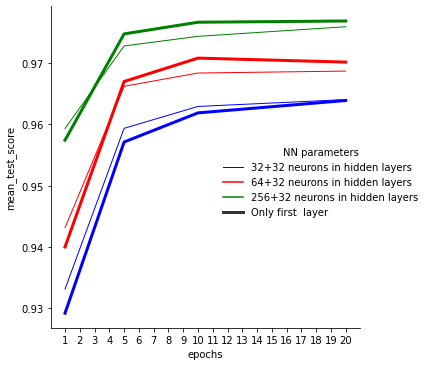

In [ ]:
cv_SVM_plot = sns.relplot(data=res, x=list(res["param_epochs"]), y="mean_test_score", size=list(res["param_hidden_size2"]), sizes=(3,1), hue=list(res["param_hidden_size"]), palette=["b", "r","g"], kind="line")
cv_SVM_plot.ax.set_xticks(np.arange(1, 21,1))
cv_SVM_plot.set(xlabel='epochs')
cv_SVM_plot._legend.set_title("NN parameters")
new_labels = [str(i)+"+32 neurons in hidden layers" for i in list(res["param_hidden_size"].unique())] + ["Only first  layer"] 
for t, l in zip(cv_SVM_plot._legend.texts, new_labels): t.set_text(l)


By plotting the result of our CV we can obtain a lot of information. First of all, we can see that adding a second layer increase the performance only when the first layer is small(thin vs thick line). Moreover, we can see that adding more neurons in the first layer made the model more accurate (different colours lines). The number of epochs also gives us some really interesting information. Increasing the number of epochs improve the result only until a given point, which is around ten for the more complex NN (red and green). After this point, the performances are stable if not worse. This can be explained by the fact that training for too much epoch could lead to an increase in the accuracy of the training set but a decrease on the validation set, an indication of overfitting. The best NN is the one trained for 20 epochs and with a single hidden layer of 256 neurons.

### Test set evaluation

We can now use the optimal NN to evaluate our test set.

In [ ]:
model = Sequential()
model.add(Dense(units=256, activation='relu', input_shape=(image_size,)))
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_label2, batch_size=128, epochs=20,  validation_split=.1)

Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_304 (Dense)            (None, 256)               200960    
_________________________________________________________________
dense_305 (Dense)            (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
422/422 [==============================] - 1s 1ms/step - loss: 0.3225 - accuracy: 0.9095 - val_loss: 0.1406 - val_accuracy: 0.9632
Epoch 2/20
422/422 [==============================] - 0s 1ms/step - loss: 0.1392 - accuracy: 0.9608 - val_loss: 0.1056 - val_accuracy: 0.9712
Epoch 3/20
422/422 [==============================] - 0s 1ms/step - loss: 0.0952 - accuracy: 0.9720 - val_loss: 0.0930 - val_accuracy: 0.9743
Epoch 4/20
422/422 [==============================] - 0s 1ms/step - loss: 0.0708 -

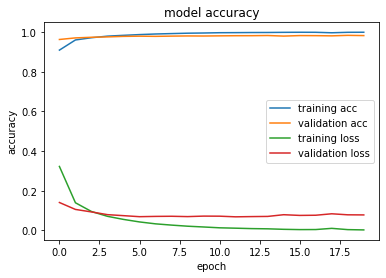

Train accuracy: 0.9997037053108215    Validation accuracy: 0.9828333258628845


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training acc', 'validation acc', 'training loss', 'validation loss'])
plt.show()
acc = (history.history['accuracy'])[-1]
val_acc = (history.history['val_accuracy'])[-1]
print(f'Train accuracy: {acc}    Validation accuracy: {val_acc}')

As we can see, our model has the expected performance, with both training and validation accuracy at high values. We can also notice that validation loss is stable if not increased after epoch 10, while the training loss is still decreasing. This could mean that we have an overfitting problem, even if small.

In [ ]:
loss, accuracy  = model.evaluate(test_images, test_label2)
print(f"Test set accuracy: {accuracy}")

313/313 [==============================] - 0s 427us/step - loss: 0.0704 - accuracy: 0.9823
Test set accuracy: 0.9822999835014343


However, the accuracy of our test set is comparable to the result we obtained in the training. We can also obtain the NN prediction to obtain a confusion matrix as we did before. We can obtain the probability summing to 1 with .predict() or already the most likely class with predict_classes(). 

In [ ]:
pred_label = model.predict_classes(test_images)
score=f1_score(test_label, pred_label, average="macro")
result["NN"]= score
print(score)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.9822978887638552


<AxesSubplot:>

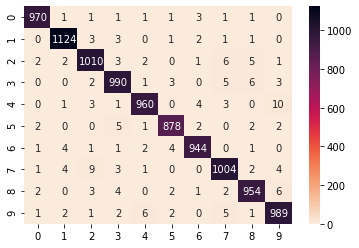

In [ ]:
cf_matrix = confusion_matrix(test_label, pred_label)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="rocket_r")

By looking at the confusion matrix no error standout. This is the best result obtained so far, with an f1-score of 0.982.

# CNN

A Convolutional Neural Network (CNN) is a Deep Learning algorithm that can take an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and is able to differentiate one from the other. They are the current state-of-art architecture for images classification tasks. The main difference between a CNN and a classic NN is how the image is provided. For a NN we use an array representing the flattened image (length NxN). A CNN instead can successfully capture the Spatial and Temporal dependencies in an image through the application of relevant filters.

### Data preparation

Before creating our CNN, we need to prepare our data. Each image must be reshaped in a format 28X28 with a single colour channel. We will use the values that are also already normalized. Our label must be also categorized as we did for NN. 

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
train_label2 = to_categorical(train_label, num_classes)
test_label2 = to_categorical(test_label, num_classes)

### Basic CNN

Now we can build our CNN. They are composed of 2 main parts: 
- Feature extraction convolutional and pooling layers
- Classification via the fully connected layers
 
The first part is used to detect features in an image, like edges and shapes. The second layer then uses this feature to do the classification task.  The architecture that we are going to use has 2 2D convolutional layers with a small filter size of 3x3 and 32 and 64 filters. They are followed by a MaxPooling layer of 2x2. The filter map then is flattened and provided as input to the Classification layer. Like before we need an output layer with 10 nodes to predict the probability distribution of an image belonging to each of the 10 classes, with the use of the softmax function. To interpret the features we add a dense layer with 64 nodes. All layers will use the ReLU activation function.

In [ ]:
CNN = Sequential()

CNN.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Conv2D(64, (3,3), activation='relu'))
CNN.add(MaxPooling2D((2,2)))

CNN.add(Flatten())
CNN.add(Dense(64, activation='relu'))
CNN.add(Dense(10, activation='softmax'))

CNN.summary()

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_306 (Dense)            (None, 64)                102464    
_________________________________________________________________
dense_307 (Dense)            (None, 10)             

Then we compile the model, using adam as optimizer, categorical_crossentropy as the loss function and accuracy as the metric to monitor the performance. 

In [ ]:
CNN.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

We train the model with training data for 25

In [ ]:
history = CNN.fit(x=train_images, 
                    y=train_label2, 
                    batch_size=256, 
                    epochs=25,
                    validation_split=0.1)

Epoch 1/25
211/211 [==============================] - 9s 44ms/step - loss: 0.3622 - accuracy: 0.8989 - val_loss: 0.0863 - val_accuracy: 0.9777
Epoch 2/25
211/211 [==============================] - 9s 45ms/step - loss: 0.0860 - accuracy: 0.9737 - val_loss: 0.0609 - val_accuracy: 0.9833
Epoch 3/25
211/211 [==============================] - 9s 44ms/step - loss: 0.0604 - accuracy: 0.9815 - val_loss: 0.0536 - val_accuracy: 0.9848
Epoch 4/25
211/211 [==============================] - 9s 44ms/step - loss: 0.0482 - accuracy: 0.9848 - val_loss: 0.0512 - val_accuracy: 0.9855
Epoch 5/25
211/211 [==============================] - 9s 44ms/step - loss: 0.0416 - accuracy: 0.9871 - val_loss: 0.0408 - val_accuracy: 0.9897
Epoch 6/25
211/211 [==============================] - 9s 44ms/step - loss: 0.0344 - accuracy: 0.9893 - val_loss: 0.0482 - val_accuracy: 0.9868
Epoch 7/25
211/211 [==============================] - 9s 44ms/step - loss: 0.0302 - accuracy: 0.9906 - val_loss: 0.0377 - val_accuracy: 0.9890

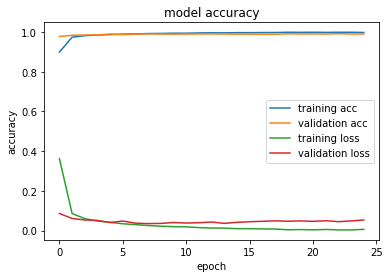

Train accuracy: 0.9977407455444336    Validation accuracy: 0.9900000095367432


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training acc', 'validation acc', 'training loss', 'validation loss'])
plt.show()
acc = (history.history['accuracy'])[-1]
val_acc = (history.history['val_accuracy'])[-1]
print(f'Train accuracy: {acc}    Validation accuracy: {val_acc}')

The results are really good, with high accuracy for Train and validation set. However, after epoch 10 we can see again a sign of overfitting, with our training loss decreasing without a decrease also in the validation loss.

In [ ]:
loss, accuracy  = CNN.evaluate(test_images, test_label2)
print(f"Test set accuracy: {accuracy}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0457 - accuracy: 0.9889
Test set accuracy: 0.9889000058174133


In [ ]:
pred_label = np.argmax(CNN.predict(test_images), axis=-1)
score=f1_score(test_label, pred_label, average="macro")
result["CNN"]= score
print(score)

0.9888112340365802


The f-1 score is 0.988, a pretty high value. However, we can still improve them by fixing some of the overfitting problems mentioned above.

## Improved CNN

To improve our previous CNN our main goal should be to limit the amount of overfitting. To do so we use a regularization technique called dropout. During training time, at each iteration, each neuron has a chance p to be disabled for the current iteration. This p is a hyperparameter called the dropout rate and we set it to 50% for each of our layers. Moreover, we increase the number of neurons in FC layers to 256.

In [ ]:
CNN2 = Sequential()

CNN2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
CNN2.add(MaxPooling2D((2,2)))
CNN2.add(Dropout(0.5))
CNN2.add(Conv2D(64, (3,3), activation='relu'))
CNN2.add(MaxPooling2D((2,2)))
CNN2.add(Dropout(0.5))
CNN2.add(Flatten())
CNN2.add(Dense(256, activation='relu'))
CNN2.add(Dropout(0.5))
CNN2.add(Dense(10, activation='softmax'))

CNN2.summary()

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)           

In [ ]:
CNN2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = CNN2.fit(x=train_images, 
                    y=train_label2, 
                    batch_size=256, 
                    epochs=25,
                    validation_split=0.1)

Epoch 1/25
211/211 [==============================] - 12s 56ms/step - loss: 0.5642 - accuracy: 0.8170 - val_loss: 0.1100 - val_accuracy: 0.9703
Epoch 2/25
211/211 [==============================] - 12s 56ms/step - loss: 0.1885 - accuracy: 0.9421 - val_loss: 0.0726 - val_accuracy: 0.9793
Epoch 3/25
211/211 [==============================] - 12s 56ms/step - loss: 0.1369 - accuracy: 0.9574 - val_loss: 0.0528 - val_accuracy: 0.9857
Epoch 4/25
211/211 [==============================] - 12s 55ms/step - loss: 0.1130 - accuracy: 0.9650 - val_loss: 0.0435 - val_accuracy: 0.9870
Epoch 5/25
211/211 [==============================] - 12s 56ms/step - loss: 0.1000 - accuracy: 0.9694 - val_loss: 0.0400 - val_accuracy: 0.9883
Epoch 6/25
211/211 [==============================] - 12s 56ms/step - loss: 0.0887 - accuracy: 0.9728 - val_loss: 0.0376 - val_accuracy: 0.9897
Epoch 7/25
211/211 [==============================] - 12s 55ms/step - loss: 0.0830 - accuracy: 0.9742 - val_loss: 0.0346 - val_accuracy:

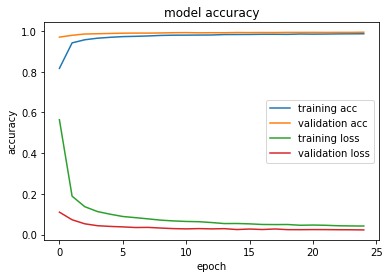

Train accuracy: 0.9868703484535217    Validation accuracy: 0.9943333268165588


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training acc', 'validation acc', 'training loss', 'validation loss'])
plt.show()
acc = (history.history['accuracy'])[-1]
val_acc = (history.history['val_accuracy'])[-1]
print(f'Train accuracy: {acc}    Validation accuracy: {val_acc}')

As we can see, both validation and training loss are decreasing during the epoch and we do not see any sign of overfitting.

### Test set evaluation

In [ ]:
loss, accuracy  = CNN2.evaluate(test_images, test_label2)
print(f"Test set accuracy: {accuracy}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0199 - accuracy: 0.9939
Test set accuracy: 0.9939000010490417


In [ ]:
pred_label = np.argmax(CNN2.predict(test_images), axis=-1)
score=f1_score(test_label, pred_label, average="macro")
result["CNN2"]= score
print(score)

0.9938521577140161


<AxesSubplot:>

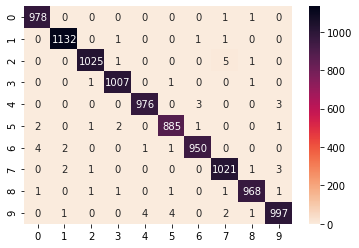

In [ ]:
cf_matrix = confusion_matrix(test_label, pred_label)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="rocket_r")

This model gets us the best result so far, with very rare errors and an f-1 score of 0,993.

# Change the data, not the model

We have seen many ways to address the classification problem from the ML point of view. However, another way to solve it is by looking at the input data. When we looked at the data at the beginning it was clear that some numbers were rotated and not perfectly centred. We can try to fix how they look before giving them to the model and see if the improved input gives better performances. This procedure is called Deskewing, which is the process of straightening an image that has been scanned or written crookedly — that is an image that is slanting too far in one direction or one that is misaligned.

### Deskewing

In [ ]:
from scipy.ndimage import interpolation


def moments(train_images):
  c0,c1 = np.mgrid[:train_images.shape[0],:train_images.shape[1]] # A trick in numPy to create a mesh grid
  totalImage = np.sum(train_images) #sum of pixels
  m0 = np.sum(c0*train_images)/totalImage #mu_x
  m1 = np.sum(c1*train_images)/totalImage #mu_y
  m00 = np.sum((c0-m0)**2*train_images)/totalImage #var(x)
  m11 = np.sum((c1-m1)**2*train_images)/totalImage #var(y)
  m01 = np.sum((c0-m0)*(c1-m1)*train_images)/totalImage #covariance(x,y)
  mu_vector = np.array([m0,m1])
  covariance_matrix = np.array([[m00,m01],[m01,m11]])
  return mu_vector, covariance_matrix

def deskew(train_images):
  c,v = moments(train_images)
  alpha = v[0,1]/v[0,0]
  affine = np.array([[1,0],[alpha,1]])
  ocenter = np.array(train_images.shape)/2.0
  offset = c-np.dot(affine,ocenter)
  return interpolation.affine_transform(train_images,affine,offset=offset)

We can appreciate the result of this operation here:

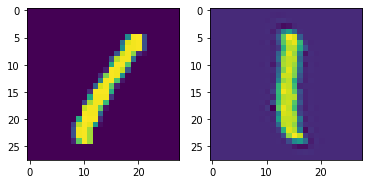

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(train_images[3].reshape(28,28))

newim = deskew(train_images[3].reshape(28,28))
plt.subplot(1, 2, 2)
plt.imshow(newim)

Now we will apply this operation to the whole dataset:

In [ ]:
def data_deskew(train_images):
    done = []
    for i in range(len(train_images)):
        done.append(deskew(train_images[i].reshape(28,28)).flatten())
    return np.array(done)

train_images_deskewed = data_deskew(train_images)
test_images_deskewed = data_deskew(test_images)


In [ ]:
train_images_deskewed = train_images_deskewed.reshape(train_images_deskewed.shape[0], 28, 28, 1)
test_images_deskewed = test_images_deskewed.reshape(test_images_deskewed.shape[0], 28, 28, 1)

### CNN with deskwed data

We will use the same model as before, but with the desked data:

In [ ]:
CNN2 = Sequential()

CNN2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
CNN2.add(MaxPooling2D((2,2)))
CNN2.add(Dropout(0.5))
CNN2.add(Conv2D(64, (3,3), activation='relu'))
CNN2.add(MaxPooling2D((2,2)))
CNN2.add(Dropout(0.5))
CNN2.add(Flatten())
CNN2.add(Dense(256, activation='relu'))
CNN2.add(Dropout(0.5))
CNN2.add(Dense(10, activation='softmax'))

CNN2.summary()

Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)           

In [ ]:
CNN2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = CNN2.fit(x=train_images_deskewed, 
                    y=train_label2, 
                    batch_size=256, 
                    epochs=25,
                    validation_split=0.1)

Epoch 1/25
211/211 [==============================] - 12s 55ms/step - loss: 0.4493 - accuracy: 0.8552 - val_loss: 0.0773 - val_accuracy: 0.9787
Epoch 2/25
211/211 [==============================] - 11s 54ms/step - loss: 0.1380 - accuracy: 0.9578 - val_loss: 0.0488 - val_accuracy: 0.9855
Epoch 3/25
211/211 [==============================] - 12s 57ms/step - loss: 0.1028 - accuracy: 0.9685 - val_loss: 0.0389 - val_accuracy: 0.9882
Epoch 4/25
211/211 [==============================] - 12s 59ms/step - loss: 0.0881 - accuracy: 0.9726 - val_loss: 0.0344 - val_accuracy: 0.9890
Epoch 5/25
211/211 [==============================] - 12s 57ms/step - loss: 0.0752 - accuracy: 0.9767 - val_loss: 0.0305 - val_accuracy: 0.9905
Epoch 6/25
211/211 [==============================] - 12s 57ms/step - loss: 0.0678 - accuracy: 0.9791 - val_loss: 0.0278 - val_accuracy: 0.9915
Epoch 7/25
211/211 [==============================] - 12s 56ms/step - loss: 0.0645 - accuracy: 0.9800 - val_loss: 0.0261 - val_accuracy:

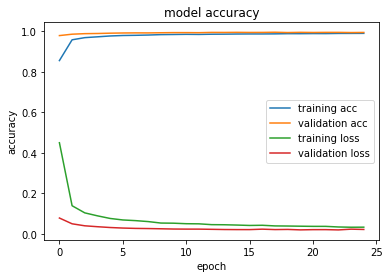

Train accuracy: 0.9897037148475647    Validation accuracy: 0.9941666722297668


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training acc', 'validation acc', 'training loss', 'validation loss'])
plt.show()
acc = (history.history['accuracy'])[-1]
val_acc = (history.history['val_accuracy'])[-1]
print(f'Train accuracy: {acc}    Validation accuracy: {val_acc}')

### Test set evaluation

In [ ]:
loss, accuracy  = CNN2.evaluate(test_images_deskewed, test_label2)
print(f"Test set accuracy: {accuracy}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0163 - accuracy: 0.9946
Test set accuracy: 0.9945999979972839


In [ ]:
pred_label = np.argmax(CNN2.predict(test_images_deskewed), axis=-1)
score=f1_score(test_label, pred_label, average="macro")
result["CNN_improved_data"]= score
print(score)

0.9945608759945015


<AxesSubplot:>

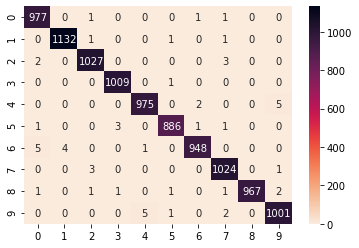

In [ ]:
cf_matrix = confusion_matrix(test_label, pred_label)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="rocket_r")

This model further improves our best results, with an f-1 score of 0,994. However, some of the images are still misclassified. We can try to have a look at them to understand why.

In [ ]:
incorrect_indices = pred_label != test_label

In [ ]:
index = [i for i, x in enumerate(incorrect_indices) if x]

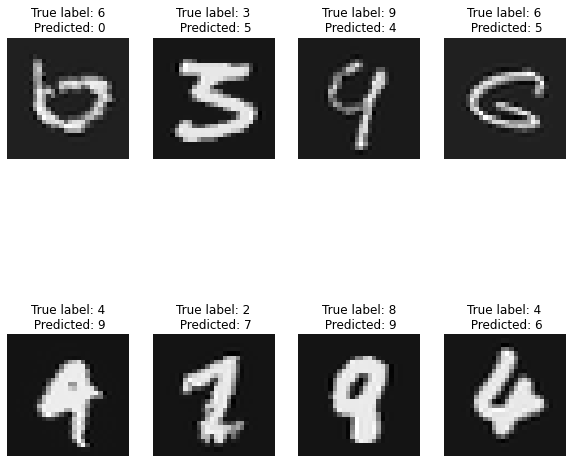

In [ ]:
a=2
b=4
fig, axs = plt.subplots(a, b, figsize=(10,10))
i=0
j=0
for val in index[:a*b]:
    axs[i, j].imshow(test_images_deskewed[val].reshape(28,28), cmap='gray')
    axs[i, j].set_title(f"True label: {str(test_label[val])}\n Predicted: {str(pred_label[val])}")
    axs[i,j].axis('off')
    if i<a-1:
        i+=1
    else:
        i=0
        j+=1

As we can see, the one misclassified by the model are digits are drawn weirdly and many of them would be also ambiguous for a human. 

# Results

(0.8, 1.0)

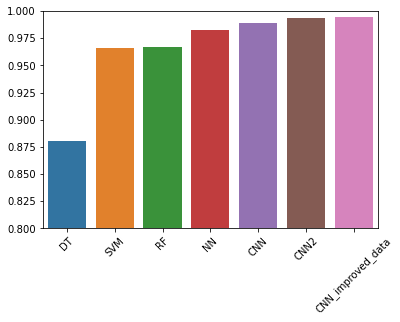

In [ ]:
keys=list(result.keys())
val=[float(result[k]) for k in result.keys()]
sns.barplot(x=keys, y=val)
plt.xticks(rotation=45)
plt.ylim(0.8, 1)

By comparing our result we can see a constant improvement of the f-1 score as the model become more complex and fine-tuned. And also we can see that deskewing the data had an impact on the performances. It's important to highlight that complex models like CNN can overcome many of the problems fixed by desking, so the improvement is small. A simpler model like DT could benefit more from this operation. Not a single model was able to obtain a perfect score yet, and this is due to the weird look of some of the images. However, our results are already quite satisfying. 